In [1]:
import matplotlib.image as mpimg
import numpy as np
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2yiq
from collections import defaultdict 
import cv2
%matplotlib inline

In [2]:
img = io.imread('test.png')
img_s = io.imread('test_s.png')
print(img.dtype, img.shape)
print(img[549, 999])
print(img_s[549, 999])
g_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
g_img_s = cv2.cvtColor(img_s, cv2.COLOR_RGB2GRAY)
print(g_img[549, 999])
print(g_img_s[549, 999])

uint8 (550, 1000, 4)
[101  83  69 255]
[101  83  69 255]
87
87


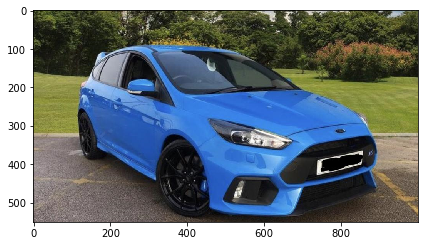

In [3]:
io.imshow(img)

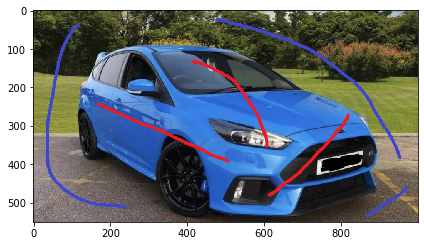

In [4]:
io.imshow(img_s)

In [5]:
scribble = []
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if g_img[i,j] !=  g_img_s[i,j]:
            scribble.append((i,j))
print(scribble)

[(21, 477), (21, 478), (21, 479), (21, 480), (21, 481), (21, 482), (21, 483), (21, 484), (21, 485), (21, 486), (21, 487), (21, 488), (21, 489), (22, 475), (22, 476), (22, 477), (22, 478), (22, 479), (22, 480), (22, 481), (22, 482), (22, 483), (22, 484), (22, 485), (22, 486), (22, 487), (22, 488), (22, 489), (22, 490), (22, 491), (22, 492), (23, 475), (23, 476), (23, 477), (23, 478), (23, 479), (23, 480), (23, 481), (23, 482), (23, 483), (23, 484), (23, 485), (23, 486), (23, 487), (23, 488), (23, 489), (23, 490), (23, 491), (23, 492), (23, 493), (23, 494), (23, 495), (23, 496), (23, 497), (24, 474), (24, 475), (24, 476), (24, 477), (24, 478), (24, 479), (24, 480), (24, 481), (24, 482), (24, 483), (24, 484), (24, 485), (24, 486), (24, 487), (24, 488), (24, 489), (24, 490), (24, 491), (24, 492), (24, 493), (24, 494), (24, 495), (24, 496), (24, 497), (24, 498), (24, 499), (24, 500), (25, 474), (25, 475), (25, 476), (25, 477), (25, 478), (25, 479), (25, 480), (25, 481), (25, 482), (25, 483)

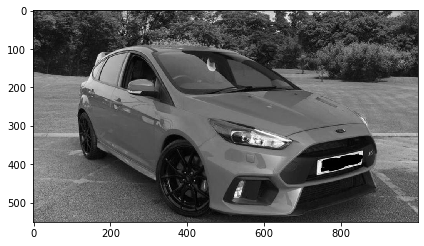

In [6]:
io.imshow(g_img)

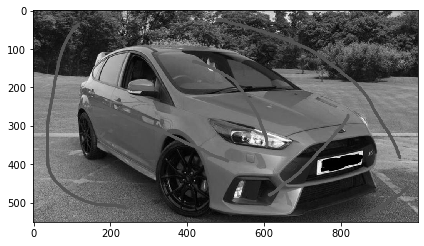

In [7]:
io.imshow(g_img_s)

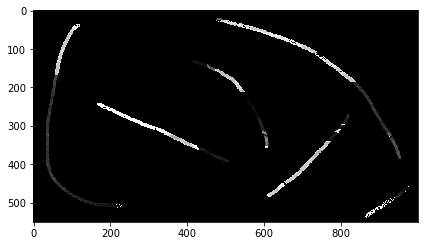

In [8]:
diff = g_img - g_img_s
io.imshow(diff)
io.imsave('diff.png', diff)

In [9]:
diff[300, 35] > 0

True

In [10]:
scribble_diff = []
for i in range(diff.shape[0]):
    for j in range(diff.shape[1]):
        if diff[i,j] > 0:
            scribble_diff.append((i,j))
print(scribble_diff)

[(21, 477), (21, 478), (21, 479), (21, 480), (21, 481), (21, 482), (21, 483), (21, 484), (21, 485), (21, 486), (21, 487), (21, 488), (21, 489), (22, 475), (22, 476), (22, 477), (22, 478), (22, 479), (22, 480), (22, 481), (22, 482), (22, 483), (22, 484), (22, 485), (22, 486), (22, 487), (22, 488), (22, 489), (22, 490), (22, 491), (22, 492), (23, 475), (23, 476), (23, 477), (23, 478), (23, 479), (23, 480), (23, 481), (23, 482), (23, 483), (23, 484), (23, 485), (23, 486), (23, 487), (23, 488), (23, 489), (23, 490), (23, 491), (23, 492), (23, 493), (23, 494), (23, 495), (23, 496), (23, 497), (24, 474), (24, 475), (24, 476), (24, 477), (24, 478), (24, 479), (24, 480), (24, 481), (24, 482), (24, 483), (24, 484), (24, 485), (24, 486), (24, 487), (24, 488), (24, 489), (24, 490), (24, 491), (24, 492), (24, 493), (24, 494), (24, 495), (24, 496), (24, 497), (24, 498), (24, 499), (24, 500), (25, 474), (25, 475), (25, 476), (25, 477), (25, 478), (25, 479), (25, 480), (25, 481), (25, 482), (25, 483)

In [11]:
scribble == scribble_diff # Need to see why 

True

In [12]:
img_s_key = set()
for i, j in scribble:
    img_s_key.add(tuple(img_s[i,j,:3]))
img_s_key # should only have two values
# Need to check that the scribbles are purely a single colour and do not shade at the edges

{(116, 117, 176),
 (103, 52, 63),
 (111, 115, 144),
 (204, 28, 35),
 (29, 33, 30),
 (104, 101, 167),
 (199, 50, 75),
 (108, 113, 148),
 (48, 14, 20),
 (116, 103, 99),
 (88, 78, 75),
 (51, 58, 46),
 (102, 106, 135),
 (71, 80, 154),
 (137, 145, 69),
 (75, 76, 134),
 (113, 109, 149),
 (231, 27, 36),
 (76, 78, 151),
 (138, 141, 71),
 (243, 143, 144),
 (85, 86, 160),
 (92, 99, 169),
 (101, 98, 161),
 (58, 64, 105),
 (137, 128, 158),
 (57, 65, 155),
 (77, 80, 180),
 (74, 74, 138),
 (63, 70, 77),
 (97, 86, 145),
 (123, 36, 40),
 (78, 122, 204),
 (82, 112, 196),
 (48, 55, 78),
 (65, 47, 52),
 (95, 91, 131),
 (129, 119, 136),
 (82, 115, 173),
 (129, 117, 123),
 (62, 72, 68),
 (130, 22, 35),
 (80, 77, 137),
 (208, 104, 104),
 (31, 35, 64),
 (119, 123, 128),
 (72, 80, 124),
 (58, 38, 37),
 (119, 127, 96),
 (78, 82, 172),
 (75, 64, 74),
 (82, 91, 109),
 (112, 81, 155),
 (163, 70, 92),
 (108, 116, 116),
 (83, 82, 147),
 (225, 33, 47),
 (62, 70, 167),
 (101, 106, 133),
 (77, 84, 186),
 (73, 64, 94),

In [13]:
# All kinda Red
print(img_s[323, 602])
print(img_s[213, 546])
print(img_s[287, 813])
print(img_s[61, 92])

# All kinda blue
print(img_s[410, 41])
print(img_s[141, 775])



[237  28  36 255]
[237  28  36 255]
[237  28  36 255]
[ 53  61 152 255]
[ 63  72 204 255]
[ 63  72 204 255]


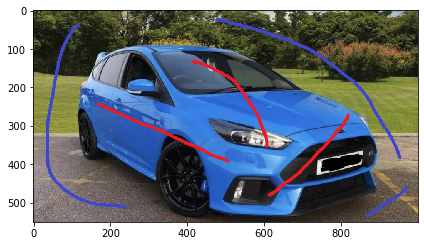

In [14]:
io.imshow(img_s)

In [15]:
if (img[549, 999] == img_s[549, 999]).all():
    print('ok')

ok


In [16]:
def compute_pdfs(imfile, imfile_scrib):
    rgb = mpimg.imread(imfile)[:,:,:3]
    yuv = rgb2yiq(rgb)
    rgb_s = mpimg.imread(imfile_scrib)[:,:,:3]
    yuv_s = rgb2yiq(rgb_s)
    # io.imshow(rgb)
    # io.imshow(rgb_s)
    def find_marked_locations(rgb, rgb_s):
        g = cv2.cvtColor(io.imread(rgb), cv2.COLOR_RGB2GRAY)
        g_s = cv2.cvtColor(io.imread(rgb_s), cv2.COLOR_RGB2GRAY)
        scribble = []
        for i in range(g.shape[0]):
            for j in range(g.shape[1]):
                if g[i,j] !=  g_s[i,j]:
                    scribble.append((i,j))
        return scribble
    
    # find the scribble pixels    
    # scribbles = find_marked_locations(rgb, rgb_s)
    scribbles = find_marked_locations(imfile, imfile_scrib)
    if not scribbles:
        raise Exception

    imageo = np.zeros(yuv.shape)
    
    # separately store background and foreground scribble pixels in the dictionary comps
    comps = defaultdict(lambda:np.array([]).reshape(0,3))
    for (i, j) in scribbles:
         imageo[i,j,:] = rgb_s[i,j,:]
         # scribble color as key of comps
         comps[tuple(imageo[i,j,:])] = np.vstack([comps[tuple(imageo[i,j,:])], yuv[i,j,:]])
         mu, Sigma = {}, {}
    # compute MLE parameters for Gaussians
    for c in comps:
         mu[c] = np.mean(comps[c], axis=0)
         Sigma[c] = np.cov(comps[c].T)
    return (mu, Sigma)

In [17]:
# Check to see what they mean
m, s = compute_pdfs('test.png', 'test_s.png')

C:\Users\nipun\envs\qcp\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\nipun\envs\qcp\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\nipun\envs\qcp\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [18]:
m

{(0.5411764979362488,
  0.5411764979362488,
  0.5882353186607361): array([ 0.59563924,  0.02357631, -0.01664675]),
 (0.4941176474094391,
  0.49803921580314636,
  0.658823549747467): array([ 0.62701179,  0.02357631, -0.01664675]),
 (0.45098039507865906,
  0.4627451002597809,
  0.6941176652908325): array([ 0.64269806,  0.02357631, -0.01664675]),
 (0.3607843220233917,
  0.364705890417099,
  0.5960784554481506): array([ 0.45175687,  0.0316636 , -0.01210814]),
 (0.45490196347236633,
  0.4588235318660736,
  0.6901960968971252): array([ 0.63607061,  0.0316636 , -0.01210814]),
 (0.5568627715110779,
  0.5607843399047852,
  0.7921568751335144): array([ 0.84391373,  0.0316636 , -0.01210814]),
 (0.5843137502670288,
  0.5882353186607361,
  0.8156862854957581): array([ 0.89400001,  0.03418394, -0.01454892]),
 (0.5411764979362488,
  0.5529412031173706,
  0.7764706015586853): array([ 0.81944707,  0.02843352, -0.01825798]),
 (0.5176470875740051,
  0.5254902243614197,
  0.7490196228027344): array([ 0.76

In [19]:
s

{(0.5411764979362488,
  0.5411764979362488,
  0.5882353186607361): array([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]),
 (0.4941176474094391,
  0.49803921580314636,
  0.658823549747467): array([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]),
 (0.45098039507865906,
  0.4627451002597809,
  0.6941176652908325): array([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]),
 (0.3607843220233917,
  0.364705890417099,
  0.5960784554481506): array([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]),
 (0.45490196347236633,
  0.4588235318660736,
  0.6901960968971252): array([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]),
 (0.5568627715110779,
  0.5607843399047852,
  0.7921568751335144): array([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]),
 (0.5843137502670288,
  0.5882353186607361,
  0.8156862854957581): array([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])

--------------------------------------------------
### Constructing BQM from g_img Intensities

In [39]:
for i, pxi in enumerate(g_img):
    for j, pxij in enumerate(pxi):
        pass
print(i, j, pxij)
g_img[0,0]

549 999 87


54

In [50]:
import math
import dimod
from tqdm import tqdm
img = io.imread('test.png')
g_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
std = np.std(g_img)
std

46.35743058460294

In [51]:
r, c = g_img.shape[:2]
bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
for i, pxi in enumerate(g_img):
    for j, pxij in enumerate(pxi):
        # Just putting Intensity for now
        bqm.add_variable(i*c + j, pxij)

for i, pxi in tqdm(enumerate(g_img)):
    for j, pxij in enumerate(pxi):
        # print(i , j)
        if i-1 >= 0:
            #Up
            a, b = i*c + j, (i-1)*c + j
            # print('UP:', a, b)
            Ia, Ib = pxij, g_img[i-1, j]
            power = ((Ia -Ib)**2)/(2*(std**2))
            bqm.add_interaction(a, b, math.exp(-power))
        if i+1 < r:
            #Down
            a, b = i*c + j, (i+1)*c + j
            # print('DOWN:', a, b)
            Ia, Ib = pxij, g_img[i+1, j]
            power = ((Ia -Ib)**2)/(2*(std**2))
            bqm.add_interaction(a, b, math.exp(-power))
        if j-1 >= 0:
            #Left
            a, b = i*c + j, i*c + (j-1)
            # print('LEFT:', a, b)
            Ia, Ib = pxij, g_img[i, j-1]
            power = ((Ia -Ib)**2)/(2*(std**2))
            bqm.add_interaction(a, b, math.exp(-power))
        if j+1 < c:
            #Right
            a, b = i*c + j, i*c + (j+1)
            # print('RIGHT:', a, b)
            Ia, Ib = pxij, g_img[i, j+1]
            power = ((Ia-Ib)**2)/(2*(std**2))
            bqm.add_interaction(a, b, math.exp(-power))

0it [00:00, ?it/s]C:\Users\nipun\envs\qcp\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Users\nipun\envs\qcp\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Users\nipun\envs\qcp\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Users\nipun\envs\qcp\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in ubyte_scalars
  app.launch_new_instance()
550it [00:50, 10.79it/s]
